In [1]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --user scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


# Random forest model

## Fine-tuning #2:

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, f_classif
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import randint, uniform


/tmp/ipykernel_1390053/2156381128.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
# Set seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [7]:

# Load the embeddings dataset
print("Loading and preprocessing data...")
data = pd.read_csv('embeddings.csv')
print(f"Dataset loaded with shape: {data.shape}")
    
# Group rare classes to handle imbalance
class_counts = data['drugclass'].value_counts()
min_samples = 10
rare_classes = class_counts[class_counts < min_samples].index.tolist()
    
# Create a new column for modified classes
data['drugclass_modified'] = data['drugclass'].apply(
    lambda x: 'other_antibiotics' if x in rare_classes else x
)
    
# Feature engineering from sequence data
print("\nPerforming enhanced feature engineering...")
    
# Basic features
X = pd.DataFrame({
    'aro_feature': data['aro'].apply(lambda x: ord(x[-1]) if len(x) > 0 else 0),
    'dna_length': data['DNAseq'].apply(len),
    'protein_length': data['Proteinseq'].apply(len),
    'gc_content': data['DNAseq'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) if len(x) > 0 else 0)
})
    
# Count the frequency of each amino acid in the protein sequence
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
for aa in amino_acids:
    X[f'aa_{aa}'] = data['Proteinseq'].apply(lambda x: x.count(aa) / len(x) if len(x) > 0 else 0)
    
# Add nucleotide frequencies
nucleotides = 'ACGT'
for nt in nucleotides:
    X[f'nt_{nt}'] = data['DNAseq'].apply(lambda x: x.count(nt) / len(x) if len(x) > 0 else 0)
    
# Add di-nucleotide frequencies for potential regulatory elements
dinucleotides = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
for di in dinucleotides:
    X[f'di_{di}'] = data['DNAseq'].apply(lambda x: x.count(di) / (len(x)-1) if len(x) > 1 else 0)
    
# Add ratios and derived features
X['purine_ratio'] = X['nt_A'] + X['nt_G']
X['pyrimidine_ratio'] = X['nt_C'] + X['nt_T']
X['at_gc_ratio'] = (X['nt_A'] + X['nt_T']) / (X['nt_G'] + X['nt_C'] + 1e-10)
    
# Add protein sequence properties
# Hydrophobic AAs
hydrophobic = 'AVILMFYW'
X['hydrophobic_ratio'] = data['Proteinseq'].apply(
    lambda x: sum(1 for aa in x if aa in hydrophobic) / len(x) if len(x) > 0 else 0
)
    
# Charged AAs
positively_charged = 'KRH'
negatively_charged = 'DE'
X['pos_charged_ratio'] = data['Proteinseq'].apply(
    lambda x: sum(1 for aa in x if aa in positively_charged) / len(x) if len(x) > 0 else 0
)
X['neg_charged_ratio'] = data['Proteinseq'].apply(
    lambda x: sum(1 for aa in x if aa in negatively_charged) / len(x) if len(x) > 0 else 0
)
X['net_charge_ratio'] = X['pos_charged_ratio'] - X['neg_charged_ratio']
    
# Use the modified drug class as the target
y = data['drugclass_modified']
print(f"Enhanced feature matrix shape: {X.shape}")
print(f"Number of features created: {X.shape[1]}")
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Loading and preprocessing data...
Dataset loaded with shape: (12117, 5)

Performing enhanced feature engineering...
Enhanced feature matrix shape: (12117, 51)
Number of features created: 51
Training set shape: (9693, 51)
Testing set shape: (2424, 51)


In [8]:
# ----- FINE-TUNING PROCESS -----
print("\n----- STARTING FINE-TUNING PROCESS -----")
# 1. Baseline model
print("\n1. Training baseline Random Forest model...")
baseline_rf = RandomForestClassifier(random_state=RANDOM_STATE)
baseline_rf.fit(X_train, y_train)
baseline_preds = baseline_rf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds, average='weighted')
    
print(f"Baseline model accuracy: {baseline_accuracy:.4f}")
print(f"Baseline model F1 score: {baseline_f1:.4f}")
    



----- STARTING FINE-TUNING PROCESS -----

1. Training baseline Random Forest model...
Baseline model accuracy: 0.2199
Baseline model F1 score: 0.2199


In [9]:
# 2. Feature selection
print("\n2. Performing feature selection...")
    
# 2.1 Initial feature importance-based selection
print("   2.1 Feature importance-based selection")
selector = SelectFromModel(estimator=baseline_rf, threshold='median')
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
    
selected_features = X.columns[selector.get_support()].tolist()
print(f"   Selected {len(selected_features)} features")
    
# Train model on selected features
rf_selected = RandomForestClassifier(random_state=RANDOM_STATE)
rf_selected.fit(X_train_selected, y_train)
selected_preds = rf_selected.predict(X_test_selected)
selected_accuracy = accuracy_score(y_test, selected_preds)
print(f"   Accuracy after feature selection: {selected_accuracy:.4f}")


2. Performing feature selection...
   2.1 Feature importance-based selection
   Selected 26 features
   Accuracy after feature selection: 0.2158


In [12]:
# 2.2 Recursive feature elimination with cross-validation
# Use a subset for RFECV to save time (can be time-consuming on large datasets)
print("   2.2 Recursive feature elimination with cross-validation")
sample_size = min(5000, X_train.shape[0])  # Use at most 5000 samples to speed up
idx = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_train_sample = X_train.iloc[idx]
y_train_sample = y_train.iloc[idx]
    
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    step=1,  # Remove one feature at a time
    cv=5,
    scoring='accuracy',
    min_features_to_select=10  # At least 10 features
)

rfecv.fit(X_train_sample, y_train_sample)
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)
        
# Train model on RFECV selected features
rf_rfecv = RandomForestClassifier(random_state=RANDOM_STATE)
rf_rfecv.fit(X_train_rfecv, y_train)
rfecv_preds = rf_rfecv.predict(X_test_rfecv)
rfecv_accuracy = accuracy_score(y_test, rfecv_preds)
        
rfecv_features = X.columns[rfecv.support_].tolist()
print(f"   RFECV selected {len(rfecv_features)} features")
print(f"   Accuracy after RFECV: {rfecv_accuracy:.4f}")
        
# Use the better feature selection result
if rfecv_accuracy > selected_accuracy:
    print("   Using RFECV feature selection")
    X_train_fs = X_train_rfecv
    X_test_fs = X_test_rfecv
    best_fs_accuracy = rfecv_accuracy
else:
    print("   Using importance-based feature selection")
    X_train_fs = X_train_selected
    X_test_fs = X_test_selected
    best_fs_accuracy = selected_accuracy


   2.2 Recursive feature elimination with cross-validation


/home/hice1/wqi49/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


   RFECV selected 45 features
   Accuracy after RFECV: 0.2158
   Using importance-based feature selection


In [13]:
# 3. Hyperparameter tuning with RandomizedSearchCV
print("\n3. Performing hyperparameter tuning...")
    
# Define hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(10, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
    
# Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings sampled
    cv=5,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='accuracy'
)
    
print("   Starting RandomizedSearchCV...")
start_time = time.time()
random_search.fit(X_train_fs, y_train)
tuning_time = time.time() - start_time
    
print(f"   Hyperparameter tuning completed in {tuning_time:.2f} seconds")
print(f"   Best parameters: {random_search.best_params_}")
print(f"   Best cross-validation score: {random_search.best_score_:.4f}")
    
# Train with best hyperparameters
best_rf = RandomForestClassifier(**random_search.best_params_, random_state=RANDOM_STATE)
best_rf.fit(X_train_fs, y_train)
best_preds = best_rf.predict(X_test_fs)
tuned_accuracy = accuracy_score(y_test, best_preds)
tuned_f1 = f1_score(y_test, best_preds, average='weighted')
    
print(f"   Tuned model accuracy: {tuned_accuracy:.4f}")
print(f"   Tuned model F1 score: {tuned_f1:.4f}")


3. Performing hyperparameter tuning...
   Starting RandomizedSearchCV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
   Hyperparameter tuning completed in 294.64 seconds
   Best parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 439}
   Best cross-validation score: 0.4231
   Tuned model accuracy: 0.4241
   Tuned model F1 score: 0.4283


In [14]:
# 4. Ensemble Learning - Option 1: Voting Classifier
print("\n4. Trying ensemble approaches...")
print("   4.1 Training Voting Classifier")
    
# Create a voting classifier with the best RF and other complementary models
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('rf2', RandomForestClassifier(
        n_estimators=200, 
        max_features='sqrt',
        bootstrap=True,
        random_state=RANDOM_STATE+1,  # Different random state
        class_weight='balanced'
    ))
], voting='soft')
    
voting_clf.fit(X_train_fs, y_train)
voting_preds = voting_clf.predict(X_test_fs)
voting_accuracy = accuracy_score(y_test, voting_preds)
voting_f1 = f1_score(y_test, voting_preds, average='weighted')
    
print(f"   Voting Classifier accuracy: {voting_accuracy:.4f}")
print(f"   Voting Classifier F1 score: {voting_f1:.4f}")


4. Trying ensemble approaches...
   4.1 Training Voting Classifier
   Voting Classifier accuracy: 0.2096
   Voting Classifier F1 score: 0.2264


In [19]:
# 5. Final Model Evaluation and Comparison
print("\n5. Final model evaluation and comparison")
    
# Collect all results
results_df = pd.DataFrame({
    'Model': ['Baseline RF', 'Feature Selected RF', 'Tuned RF', 'Voting Classifier'],
    'Accuracy': [baseline_accuracy, best_fs_accuracy, tuned_accuracy, voting_accuracy],
    'F1 Score': [baseline_f1, None, tuned_f1, voting_f1],
    'Improvement': [0, best_fs_accuracy - baseline_accuracy, 
                    tuned_accuracy - baseline_accuracy, 
                    voting_accuracy - baseline_accuracy]
})
    
print("\nModel Performance Comparison:")
print(results_df)
    
# Select the best model based on accuracy
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model_accuracy = results_df['Accuracy'].max()
    
if best_model_name == 'Voting Classifier':
    best_model = voting_clf
elif best_model_name == 'Tuned RF':
    best_model = best_rf
elif best_model_name == 'Feature Selected RF':
    best_model = rf_selected if selected_accuracy > rfecv_accuracy else rf_rfecv
else:
    best_model = baseline_rf
    
print(f"\nBest model: {best_model_name} with accuracy: {best_model_accuracy:.4f}")
    
# Final evaluation on test set
final_preds = best_model.predict(X_test_fs if best_model_name != 'Baseline RF' else X_test)
    
print("\nFinal Classification Report:")
print(classification_report(y_test, final_preds))



5. Final model evaluation and comparison

Model Performance Comparison:
                 Model  Accuracy  F1 Score  Improvement
0          Baseline RF  0.219884  0.219908     0.000000
1  Feature Selected RF  0.215759       NaN    -0.004125
2             Tuned RF  0.424092  0.428255     0.204208
3    Voting Classifier  0.209571  0.226361    -0.010314

Best model: Tuned RF with accuracy: 0.4241

Final Classification Report:
                                     precision    recall  f1-score   support

           aminocoumarin antibiotic       0.02      0.50      0.04         2
          aminoglycoside antibiotic       0.57      0.52      0.55        46
                         carbapenem       0.46      0.31      0.37       489
                      cephalosporin       0.62      0.43      0.51       691
       diaminopyrimidine antibiotic       0.52      0.52      0.52        21
disinfecting agents and antiseptics       0.06      0.17      0.09        12
         fluoroquinolone antibiot

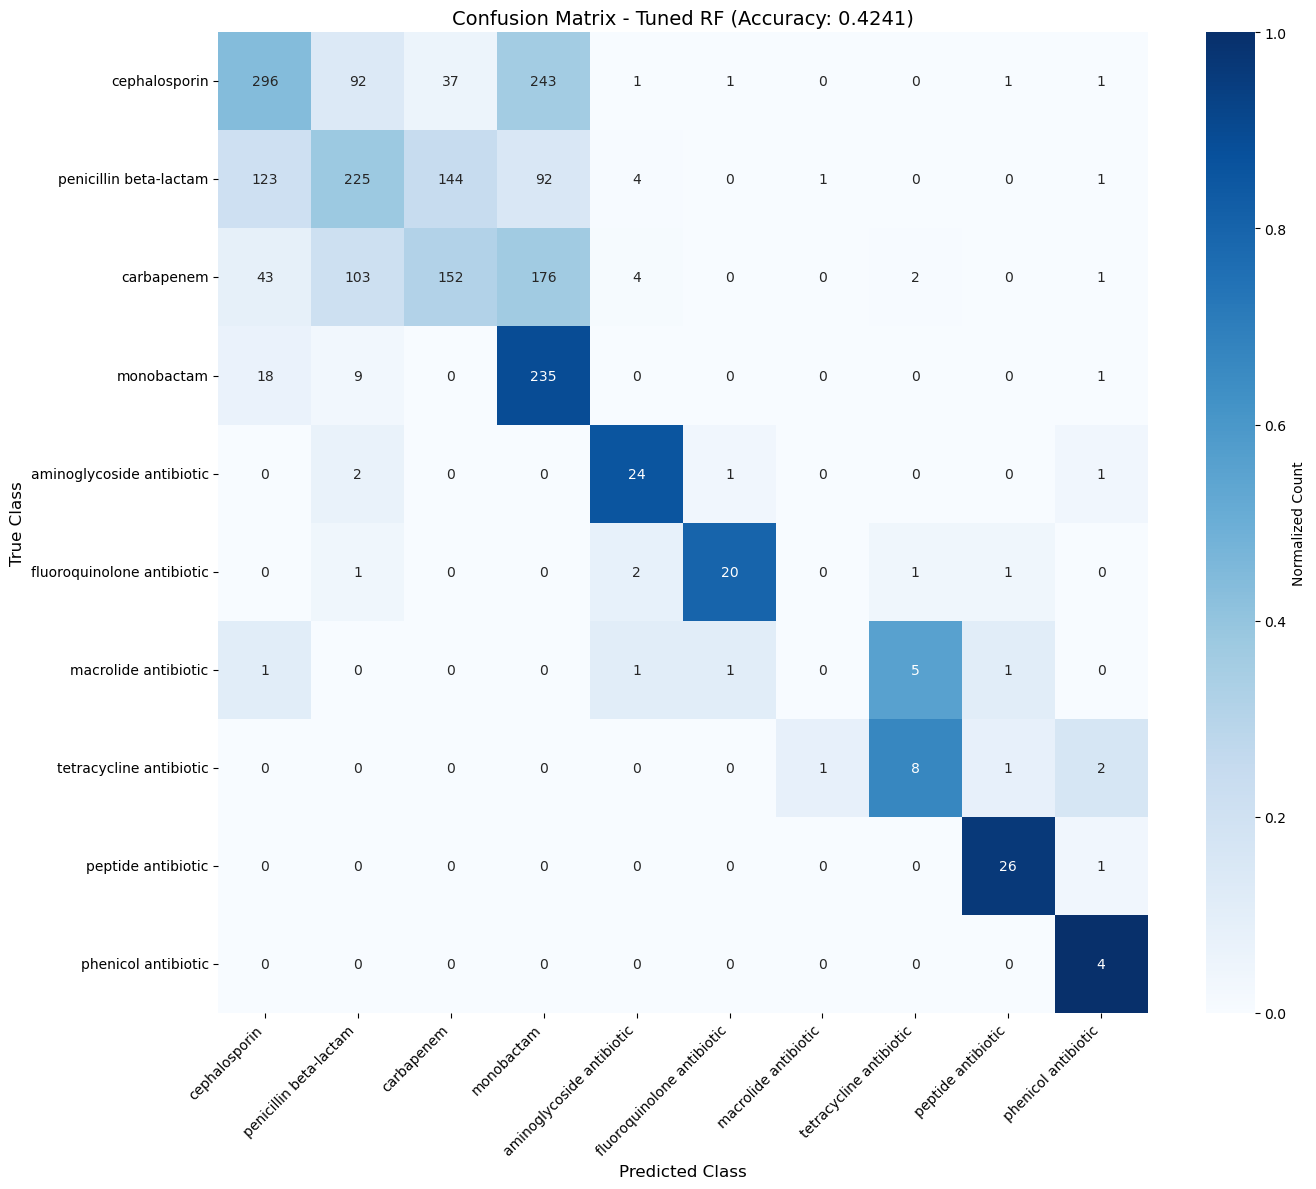

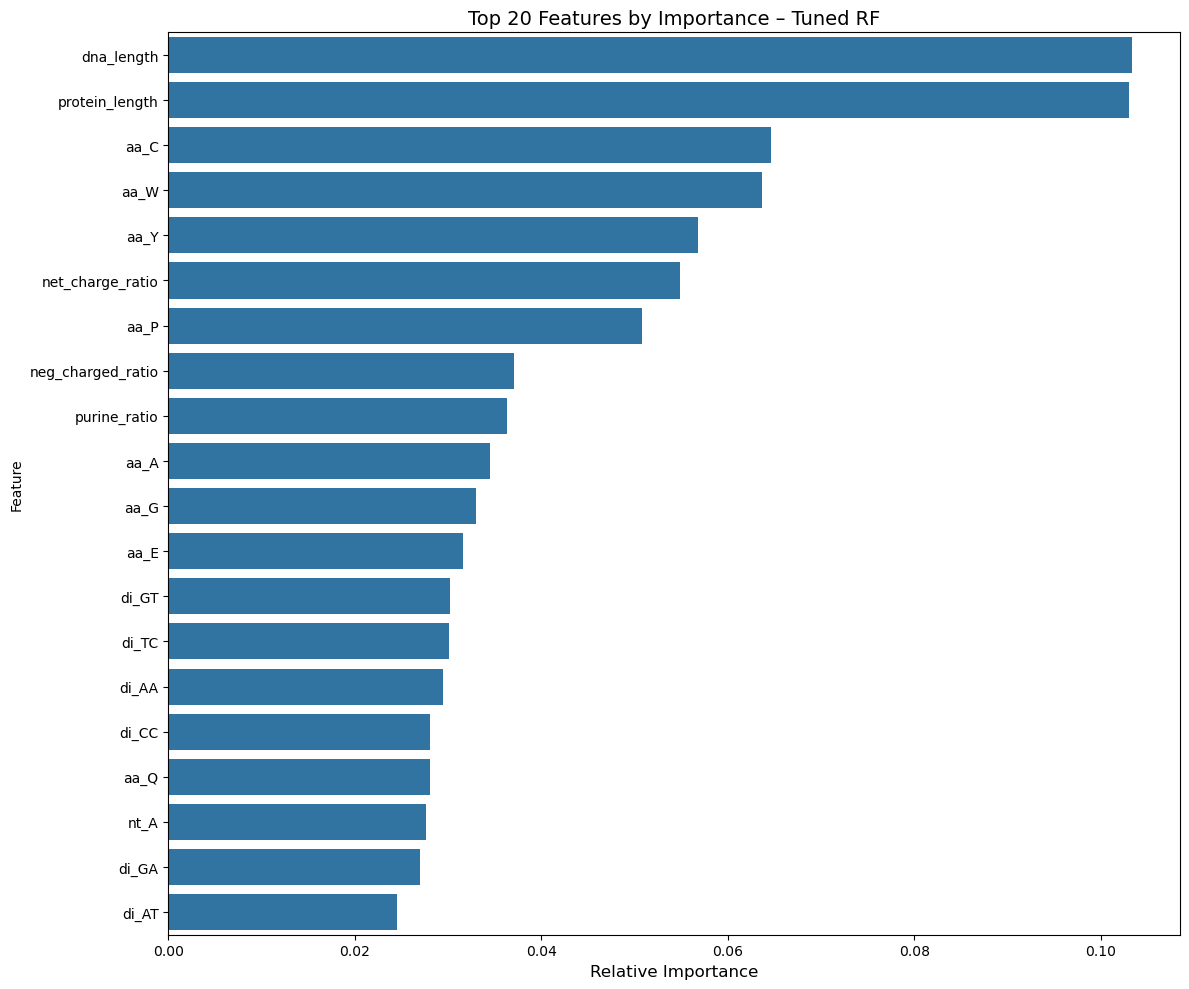

In [26]:
# Plot confusion matrix for top classes
top_classes = data['drugclass_modified'].value_counts().head(10).index.tolist()
mask_test = y_test.isin(top_classes)
y_test_top = y_test[mask_test]
y_pred_top = np.array(final_preds)[mask_test]
    
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test_top, y_pred_top, labels=top_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', 
            xticklabels=top_classes, yticklabels=top_classes,
            cbar_kws={'label': 'Normalized Count'})
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.title(f'Confusion Matrix - {best_model_name} (Accuracy: {best_model_accuracy:.4f})', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('fine_tuned_confusion_matrix.png', dpi=300)
    
# ------------------------------------------------------------------
#  Feature importance of the best model (if applicable)
# ------------------------------------------------------------------

# Get the mask that was actually used for training ---------------
if best_model_name == "Baseline RF":                # all features kept
    selected_mask = np.ones(X.shape[1], dtype=bool)
elif rfecv_accuracy > selected_accuracy:            # RFECV won
    selected_mask = rfecv.support_
else:                                               # importance-based selector won
    selected_mask = selector.get_support()

selected_feature_names = X.columns[selected_mask]

# Extract importances from the trained model --------------------
if hasattr(best_model, "feature_importances_"):
    feature_importances = best_model.feature_importances_
elif hasattr(best_model, "estimators_") and hasattr(best_model.estimators_[0], "feature_importances_"):
    # e.g. a Voting or Bagging ensemble that wraps RFs
    feature_importances = best_model.estimators_[0].feature_importances_
else:
    print("The chosen best_model has no feature_importances_. Skipping plot.")
    feature_importances = None

# Build the DataFrame and plot if lengths match -----------------
if feature_importances is not None:
    if len(feature_importances) != len(selected_feature_names):
        print("Length mismatch:"
              f" {len(feature_importances)} importances vs"
              f" {len(selected_feature_names)} feature names."
              " Skipping feature-importance plot.")
    else:
        feature_importance = (
            pd.DataFrame({
                "Feature": selected_feature_names,
                "Importance": feature_importances
            })
            .sort_values("Importance", ascending=False)
        )

        # top‑20 bar plot
        plt.figure(figsize=(12, 10))
        sns.barplot(
            x="Importance",
            y="Feature",
            data=feature_importance.head(20)
        )
        plt.title(f"Top 20 Features by Importance – {best_model_name}", fontsize=14)
        plt.xlabel("Relative Importance", fontsize=12)
        plt.tight_layout()
        plt.savefig("fine_tuned_feature_importance.png", dpi=300)
        plt.show()
